In [ ]:

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)


import  matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)  # To ignore warnings due to deprecated functions

%matplotlib inline

In [9]:
# Load the original and encoded datasets
df_original = pd.read_csv("/preprocessed.csv", header=None, low_memory=False)
df_encoded = pd.read_csv("/preprocessed_encoded.csv", header=None, low_memory=False)

# Extract the 'match' column from the original dataset
match_column = df_original.iloc[:, -1]

# Append the 'match' column to the encoded dataset
df_encoded = pd.concat([df_encoded, match_column.rename('match')], axis=1)

# Convert all columns to numeric, coercing errors to handle non-numeric gracefully
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Drop rows with any non-numeric values that couldn't be coerced
df_encoded = df_encoded.dropna()

# Extract features and target variable
y = df_encoded['match'].values
X = df_encoded.drop(columns=['match']).values

# Split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)




# Inspect the first few rows
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,match
1,1.0,21.0,27.0,6.0,2.0,4.0,35.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,21.0,22.0,1.0,2.0,4.0,60.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,21.0,22.0,1.0,2.0,4.0,19.0,18.0,19.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,21.0,23.0,2.0,2.0,4.0,30.0,5.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,21.0,24.0,3.0,2.0,4.0,30.0,10.0,20.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# The dataset is divided into k subsets or folds
cv = 30

clf1 = GaussianNB()

params = {
    "n_neighbors": list(range(1,30,2)),
    "weights": ("distance", "uniform")
}
knc = KNeighborsClassifier()
clf = GridSearchCV(
    knc,
    param_grid = params,
    cv = cv,
    n_jobs = -1
)
clf.fit(X_train, y_train)
print(f"Best Params fo Knn = {clf.best_params_}  -  Accuracy = {clf.best_score_}")

parval = clf.best_params_
clf2 = KNeighborsClassifier(
    n_neighbors = parval["n_neighbors"],
    weights = parval["weights"]
)

clf3 = DecisionTreeClassifier(criterion = "entropy")

for clf, label in zip([clf1, clf2, clf3], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    clf.fit(X_train, y_train)  # Train on training data
    scores = cross_val_score(
        clf,
        X_test,
        y_test,
        cv = cv,
        scoring = "accuracy"
    )

    print("Accuracy: %0.3f [%s]" % (scores.mean(), label))  # TODO: update this part


Best Params fo Knn = {'n_neighbors': 21, 'weights': 'distance'}  -  Accuracy = 0.8364663410207133
Accuracy: 0.383 [Naive Bayes]
Accuracy: 0.837 [Knn (3)]
Accuracy: 0.803 [Dec. Tree]


In [11]:

# Define the voting classifier with the already fitted classifiers
eclf = VotingClassifier(
    estimators=[
        ("nb", clf1),
        ("knn3", clf2),
        ("dt", clf3)
    ],
    voting="hard"
)

# Train the voting classifier on the training data
eclf.fit(X_train, y_train)

# Evaluate the voting classifier on the test data
scores = cross_val_score(
    eclf,
    X_test,
    y_test,
    cv=cv,
    scoring="accuracy"
)

print("Accuracy: %0.3f [%s]" % (scores.mean(), "Majority Voting"))

Accuracy: 0.809 [Majority Voting]


In [12]:
# Define the voting classifier with the already fitted classifiers and weights
eclf = VotingClassifier(
    estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],
    voting='soft',
    weights=[2, 1, 2]
)

# Train the voting classifier on the training data
eclf.fit(X_train, y_train)

# Evaluate the voting classifier on the test data
scores = cross_val_score(eclf, X_test, y_test, cv=cv, scoring='accuracy')

print("Accuracy: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Accuracy: 0.809 [Weighted Voting]


In [13]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier

# Define the voting classifier with corrected parameters
eclf = VotingClassifier(
    estimators=[
        ("nb", clf1),
        ("knn3", clf2),
        ("dt", clf3)
    ],
    voting="hard"
)

# Train the voting classifier on the training data
eclf.fit(X_train, y_train)

# Define a dictionary of metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')
}

# Evaluate and print scores for the voting classifier
print("Voting Classifier (Hard Voting):")
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(
        eclf,
        X_test,
        y_test,
        cv=cv,
        scoring=metric
    )
    print(f"{metric_name.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")

# Example for BaggingClassifier with corrected parameter
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=0
)

# Train the bagging classifier on the training data
bagging_clf.fit(X_train, y_train)

# Evaluate and print scores for the bagging classifier
print("\nBagging Classifier with Decision Trees:")
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(
        bagging_clf,
        X_test,
        y_test,
        cv=cv,
        scoring=metric
    )
    print(f"{metric_name.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")


Voting Classifier (Hard Voting):
Accuracy: 0.809 ± 0.038
Precision: 0.640 ± 0.093
Recall: 0.618 ± 0.067
F1: 0.616 ± 0.078
Roc_auc: 0.605 ± 0.064

Bagging Classifier with Decision Trees:
Accuracy: 0.842 ± 0.034
Precision: 0.698 ± 0.142
Recall: 0.600 ± 0.067
F1: 0.618 ± 0.089
Roc_auc: 0.600 ± 0.067


In [14]:
from sklearn.ensemble import RandomForestClassifier

lrf = []
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the RandomForestClassifier on the training data
    rf_clf = RandomForestClassifier(n_estimators=nest)
    rf_clf.fit(X_train, y_train)

    # Evaluate the RandomForestClassifier on the test data
    scores = cross_val_score(rf_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())

Accuracy: 0.776 [1]
Accuracy: 0.829 [2]
Accuracy: 0.823 [5]
Accuracy: 0.842 [10]
Accuracy: 0.840 [20]
Accuracy: 0.840 [50]
Accuracy: 0.842 [100]
Accuracy: 0.839 [200]


In [15]:
from sklearn.ensemble import ExtraTreesClassifier

lext = []
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the ExtraTreesClassifier on the training data
    ext_clf = ExtraTreesClassifier(n_estimators=nest)
    ext_clf.fit(X_train, y_train)

    # Evaluate the ExtraTreesClassifier on the test data
    scores = cross_val_score(ext_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())


Accuracy: 0.767 [1]
Accuracy: 0.829 [2]
Accuracy: 0.814 [5]
Accuracy: 0.840 [10]
Accuracy: 0.840 [20]
Accuracy: 0.835 [50]
Accuracy: 0.835 [100]
Accuracy: 0.841 [200]


In [16]:
from sklearn.ensemble import AdaBoostClassifier

lboo = []
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the AdaBoostClassifier on the training data
    ada_clf = AdaBoostClassifier(n_estimators=nest)
    ada_clf.fit(X_train, y_train)

    # Evaluate the AdaBoostClassifier on the test data
    scores = cross_val_score(ada_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())


Accuracy: 0.837 [1]
Accuracy: 0.836 [2]
Accuracy: 0.843 [5]
Accuracy: 0.843 [10]
Accuracy: 0.836 [20]
Accuracy: 0.832 [50]
Accuracy: 0.836 [100]
Accuracy: 0.828 [200]


In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

lboodt = []
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the AdaBoostClassifier with DecisionTreeClassifier on the training data
    ada_dt_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=5),
        n_estimators=nest
    )
    ada_dt_clf.fit(X_train, y_train)

    # Evaluate the AdaBoostClassifier with DecisionTreeClassifier on the test data
    scores = cross_val_score(ada_dt_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())


Accuracy: 0.837 [1]
Accuracy: 0.829 [2]
Accuracy: 0.812 [5]
Accuracy: 0.810 [10]
Accuracy: 0.819 [20]
Accuracy: 0.836 [50]
Accuracy: 0.842 [100]
Accuracy: 0.848 [200]


In [18]:

from sklearn.ensemble import GradientBoostingClassifier

lgbboo = []
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the GradientBoostingClassifier on the training data
    gb_clf = GradientBoostingClassifier(n_estimators=nest)
    gb_clf.fit(X_train, y_train)

    # Evaluate the GradientBoostingClassifier on the test data
    scores = cross_val_score(gb_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print(f"Accuracy: {scores.mean():.3f} [{nest}]")
    lgbboo.append(scores.mean())


Accuracy: 0.837 [1]
Accuracy: 0.837 [2]
Accuracy: 0.837 [5]
Accuracy: 0.835 [10]
Accuracy: 0.847 [20]
Accuracy: 0.851 [50]
Accuracy: 0.849 [100]
Accuracy: 0.842 [200]


In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

lb = []

for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the BaggingClassifier on the training data
    bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=nest)
    bag_clf.fit(X_train, y_train)

    # Evaluate the BaggingClassifier on the test data
    scores = cross_val_score(bag_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print(f"Accuracy: {scores.mean():.3f} [{nest}]")
    lb.append(scores.mean())


Accuracy: 0.776 [1]
Accuracy: 0.823 [2]
Accuracy: 0.824 [5]
Accuracy: 0.837 [10]
Accuracy: 0.847 [20]
Accuracy: 0.847 [50]
Accuracy: 0.853 [100]
Accuracy: 0.849 [200]


In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

lll = []

for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    # Train the BaggingClassifier with max_features on the training data
    bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=nest, max_features=0.35)
    bag_clf.fit(X_train, y_train)

    # Evaluate the BaggingClassifier on the test data
    scores = cross_val_score(bag_clf, X_test, y_test, cv=cv, scoring='accuracy')
    print(f"Accuracy: {scores.mean():.3f} [{nest}]")
    lll.append(scores.mean())


Accuracy: 0.764 [1]
Accuracy: 0.840 [2]
Accuracy: 0.823 [5]
Accuracy: 0.840 [10]
Accuracy: 0.840 [20]
Accuracy: 0.841 [50]
Accuracy: 0.838 [100]
Accuracy: 0.842 [200]


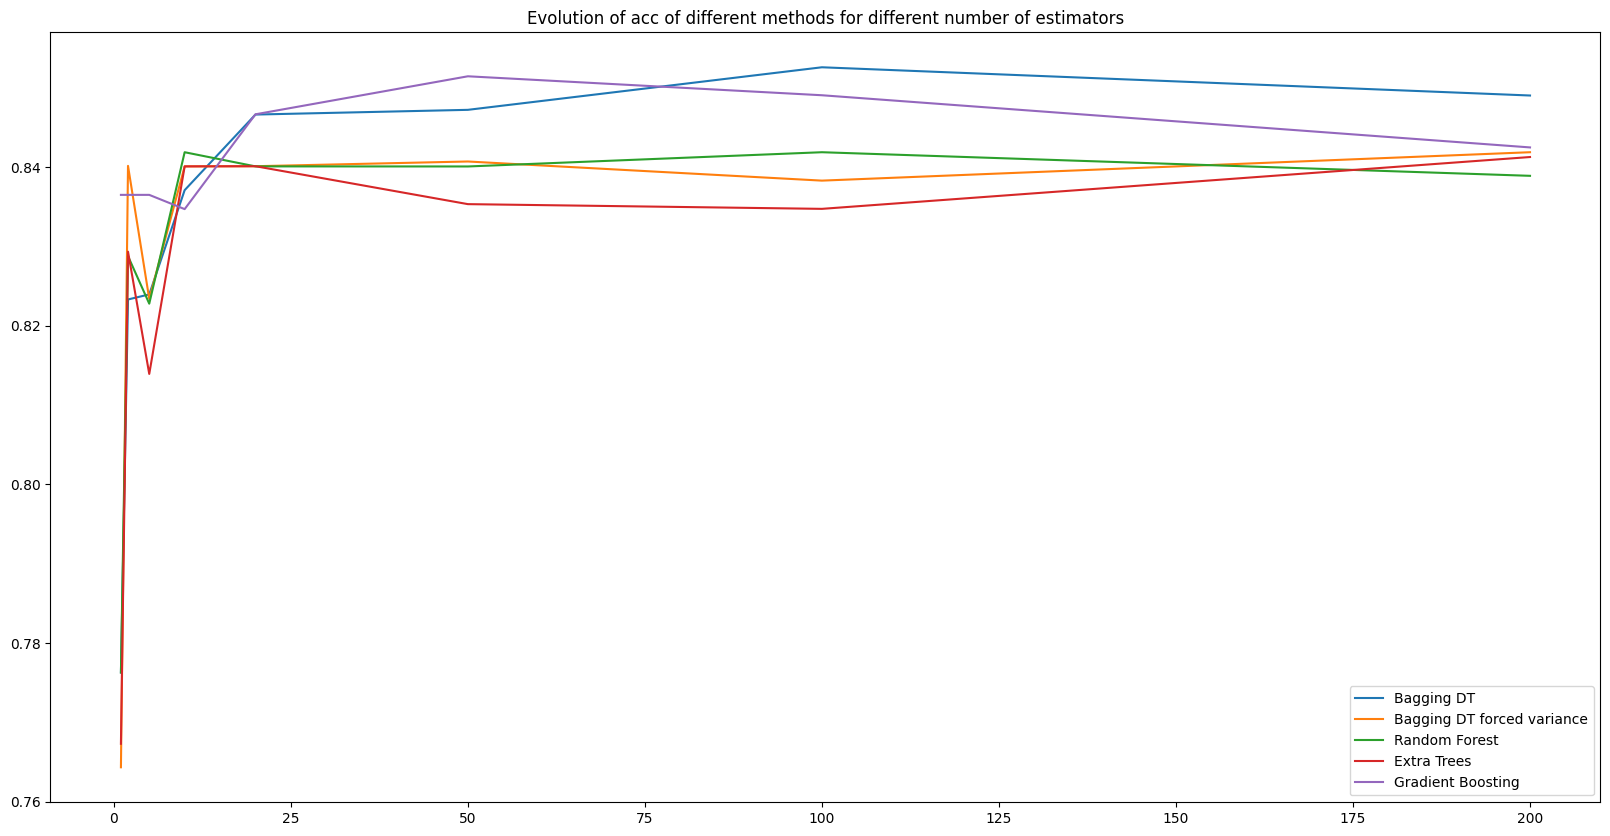

In [21]:
#from scipy.constants import lb

plt.figure(figsize = (20, 10))
plt.title("Evolution of acc of different methods for different number of estimators")
plt.plot([1,2,5,10,20,50,100,200],lb,label = "Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lll,label = "Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label = "Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label = "Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label = "Gradient Boosting")
plt.legend(loc = "lower right")
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Train the RandomForestClassifier on the training data
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

# Print feature importances
print(clf.feature_importances_)

# Create a dictionary to store the top features
topFutures = {}
for feature in range(len(clf.feature_importances_)):
    topFutures[feature] = clf.feature_importances_[feature]


[1.16916837e-02 1.38087870e-02 1.91301575e-02 1.68271048e-02
 1.01163554e-02 9.02840676e-03 1.87497867e-02 1.78383427e-02
 1.80447385e-02 1.82770267e-02 1.72273452e-02 1.73957398e-02
 3.81100424e-02 1.70816460e-02 1.59744407e-02 3.54803595e-02
 1.55720586e-02 3.32776809e-02 1.44139274e-02 1.27514309e-02
 1.29051257e-02 1.24251813e-02 1.23565074e-02 1.36928363e-02
 1.07243065e-02 7.88099095e-03 8.30100107e-03 7.24396548e-03
 1.03541539e-02 3.31913827e-02 1.44919224e-02 1.33978073e-02
 2.84693656e-02 1.35679826e-02 3.17937170e-02 1.08559784e-02
 1.04947073e-02 1.07913428e-02 9.31547477e-03 9.57111956e-03
 9.51762513e-03 1.13273715e-02 1.09911590e-02 1.21694807e-02
 9.77716896e-03 1.07701284e-02 1.07814576e-02 9.21736398e-03
 1.10747569e-02 9.48615001e-03 1.11332309e-02 1.20453451e-02
 2.41253780e-02 9.78850236e-03 1.64176832e-02 3.62078538e-02
 2.99895193e-02 6.30614649e-03 2.67770804e-03 2.88378841e-03
 3.95118255e-04 3.11271964e-03 1.61935574e-03 3.14998421e-03
 1.75379840e-03 1.429117

In [23]:
from sklearn.feature_selection import SelectFromModel


# Train the RandomForestClassifier on the training data
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

# Lowered threshold to 0.03
model = SelectFromModel(clf, prefit=True, threshold=0.03)

# Transform the training and test data
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print(X_train_new.shape)
print(X_test_new.shape)

# Calculate accuracy before feature selection
accuracy_before = np.mean(cross_val_score(KNeighborsClassifier(), X=X_test, y=y_test, cv=cv, scoring="accuracy"))
print("accuracy before feature selection: " + str(accuracy_before))

# Calculate accuracy after feature selection
accuracy_after = np.mean(cross_val_score(KNeighborsClassifier(), X=X_test_new, y=y_test, cv=cv, scoring="accuracy"))
print("accuracy after feature selection: " + str(accuracy_after))


(6702, 5)
(1676, 5)
accuracy before feature selection: 0.8150000000000002
accuracy after feature selection: 0.8437662337662338


In [ ]:
thresholds = clf.feature_importances_

# Train the RandomForestClassifier on the training data
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

# Extract feature importances
thresholds = clf.feature_importances_

l = []
lparval = []

for threshold in thresholds:
    # Apply feature selection
    model = SelectFromModel(clf, prefit=True, threshold=threshold)

    # Transform both the training and test data
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)

    params = {
        "n_neighbors": list(range(1, 30, 2)),
        "weights": ("distance", "uniform")
    }

    knc = KNeighborsClassifier()
    clf2 = GridSearchCV(knc, param_grid=params, cv=cv, n_jobs=-1)
    clf2.fit(X_train_new, y_train)
    parval = clf2.best_params_

    clf3 = KNeighborsClassifier(n_neighbors=parval["n_neighbors"], weights=parval["weights"])

    acc = np.mean(cross_val_score(clf3, X=X_test_new, y=y_test, cv=cv, scoring="accuracy"))
    l.append(acc)
    lparval.append(parval)

plt.scatter(thresholds, l)
plt.xlabel('Feature Importance Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Feature Importance Threshold')
plt.show()

print(f"Best threshold: {thresholds[np.argmax(l)]}")


In [ ]:
parval = lparval[np.argmax(l)]
model = SelectFromModel(clf, prefit=True, threshold=thresholds[np.argmax(l)])

# Transform both training and test data
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)

print(f"Shape of transformed training data: {X_train_new.shape}")
print(f"Shape of transformed test data: {X_test_new.shape}")

# Calculate original accuracy on test data
original_accuracy = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X_test, y=y_test, cv=cv, scoring='accuracy'))
print(f"Original: {original_accuracy}")

# Calculate accuracy with feature selection on test data
accuracy_with_fs = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=parval['n_neighbors'], weights=parval['weights']), X=X_test_new, y=y_test, cv=cv, scoring='accuracy'))
print(f"With FS: {accuracy_with_fs}")